In [1]:
real=None

anime=None

In [38]:
# data_loader

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import os
from torch.backends import cudnn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
import pickle
from skimage import io
import numpy as np
from PIL import Image
import scipy.misc
from torch.autograd import Variable
from torch import optim
from time import time



class FaceDataset(Dataset):

    def __init__(self, root_dir, name, transform=None, load=False):
        self.name = name
        self.root_dir = root_dir
        self.transform = transform
        if load:
            self.imgs, self.fnames = self.load()
        else:
            imgs = []
            self.fnames = []
    #         te = np.zeros((len(self.fnames), 3, 64, 64))
            for i, fname in enumerate(os.listdir(root_dir)):
                if not i % 1000:
                    print(i)
                img_name = os.path.join(self.root_dir, fname)
                image = Image.open(img_name)
                if image.mode == 'RGB':
                    image = self.transform(image)
                    self.fnames.append(fname)
                    imgs.append(image)
            self.fnames = np.array(self.fnames)
            self.imgs = torch.stack(imgs)

            self.save()
#         te[i] = image.numpy()
#         print(te.max(), te.min())
#         plt.show(plt.imshow(np.transpose(te[1000]/2+0.5, (1, 2, 0))))
#         print(np.mean(te[:, 0, :, :]), np.mean(te[:, 1, :, :]), np.mean(te[:, 2, :, :]))
#         print(np.std(te[:, 0, :, :]), np.std(te[:, 1, :, :]), np.std(te[:, 2, :, :]))

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        return self.imgs[idx]
    
    def save(self):
        np.save(self.name+"_fn.npy", self.fnames)
        torch.save(self.imgs, self.name+"_im")

    
    def load(self):
        return torch.load(self.name+"_im"), np.load(self.name+"_fn.npy")

def get_loader(config, real=None, anime=None, load=False):
    transform = transforms.Compose([
                    transforms.Scale((config.image_size, config.image_size)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#     if real is None:
    real = FaceDataset(root_dir=config.real_path, name="real_data", transform=transform, load=False)
    anime = FaceDataset(root_dir=config.anime_path, name="anime_data", transform=transform, load=load)
#         return real, anime
    
    real_loader = DataLoader(dataset=real,
                                              batch_size=config.batch_size,
                                              shuffle=True,
                                              num_workers=config.num_workers)

    anime_loader = DataLoader(dataset=anime,
                                               batch_size=config.batch_size,
                                               shuffle=True,
                                               num_workers=config.num_workers)
    return real_loader, anime_loader



In [3]:
# model


def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom deconvolutional layer for simplicity."""
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom convolutional layer for simplicity."""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

class G(nn.Module):
    """Generator"""
    def __init__(self, conv_dim=64):
        super(G, self).__init__()
        # encoding blocks
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        
        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        
        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 3, 4, bn=False)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 32, 32)
        out = nn.Dropout()(out)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 16, 16)
        
        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = nn.Dropout()(out)
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )
        
        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 32, 32)
        out = nn.Dropout()(out)
        out = F.tanh(self.deconv2(out))              # (?, 3, 64, 64)
        return out

    
class D(nn.Module):
    """Discriminator"""
    def __init__(self, conv_dim=64):
        super(D, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 32, 32)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 16, 16)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 8, 8)
        out = self.fc(out).squeeze()
        return out

In [22]:
# solver


class Solver(object):
    def __init__(self, config, real_loader, anime_loader):
        self.real_loader = real_loader
        self.anime_loader = anime_loader
        self.g12 = None
        self.g21 = None
        self.d1 = None
        self.d2 = None
        self.g_optimizer = None
        self.d_optimizer = None
        self.use_reconst_loss = config.use_reconst_loss
        self.beta1 = config.beta1
        self.beta2 = config.beta2
        self.g_conv_dim = config.g_conv_dim
        self.d_conv_dim = config.d_conv_dim
        self.train_iters = config.train_iters
        self.batch_size = config.batch_size
        self.lr = config.lr
        self.log_step = config.log_step
        self.sample_step = config.sample_step
        self.sample_path = config.sample_path
        self.model_path = config.model_path
        self.build_model()
        
    def build_model(self):
        """Builds a generator and a discriminator."""
        self.g12 = G(conv_dim=self.g_conv_dim)
        self.g21 = G(conv_dim=self.g_conv_dim)
        self.d1 = D(conv_dim=self.d_conv_dim)
        self.d2 = D(conv_dim=self.d_conv_dim)
        
        g_params = list(self.g12.parameters()) + list(self.g21.parameters())
        d_params = list(self.d1.parameters()) + list(self.d2.parameters())
        
        self.g_optimizer = optim.Adam(g_params, self.lr, [self.beta1, self.beta2])
        self.d_optimizer = optim.Adam(d_params, self.lr, [self.beta1, self.beta2])
        
        if torch.cuda.is_available():
            self.g12.cuda()
            self.g21.cuda()
            self.d1.cuda()
            self.d2.cuda()
    
    def merge_images(self, sources, targets, k=10):
#         print(sources.shape, targets.shape)
        _, _, h, w = sources.shape
        if k = 0:
            rows=1
        else:
            rows = int(np.sqrt(sources.shape[0]))
        merged = np.zeros([3, rows*h, rows*w*2])
#         print(merged.shape)
        for idx, (s, t) in enumerate(zip(sources, targets)):
#             print([(idx // rows)*h,((idx // rows)+1)*h, 2*(idx % rows)*w,(2*(idx % rows)+1)*w])
#             print(s.shape, t.shape)
            merged[:, (idx // rows)*h:((idx // rows)+1)*h, 2*(idx % rows)*w:(2*(idx % rows)+1)*w] = s
            merged[:, (idx // rows)*h:((idx // rows)+1)*h, (2*(idx % rows)+1)*w:(2*(idx % rows)+2)*w] = t
        return merged.transpose(1, 2, 0)
    
    def to_var(self, x):
        """Converts numpy to variable."""
        if torch.cuda.is_available():
            x = x.cuda()
        return Variable(x)
    
    def to_data(self, x):
        """Converts variable to numpy."""
        if torch.cuda.is_available():
            x = x.cpu()
        return x.data.numpy()
    
    def reset_grad(self):
        """Zeros the gradient buffers."""
        self.g_optimizer.zero_grad()
        self.d_optimizer.zero_grad()

    def plot_history(self, *history):
#         print(history)
        if len(history[0]) <= 20:
            return
        for h, t in zip(history, ["d_anime_loss", "d_real_loss", "d_fake_anime_loss", "d_fake_real_loss", "g_loss12", "g_loss21"]):
            plt.figure()
            plt.title('{}'.format(t))
            plt.plot(h[20:], label='train', zorder=1)
    #         points = np.array(val_history)
    #         plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
            plt.xlabel('train steps')
            plt.legend(loc='best')
            plt.grid()
            plt.show()
    
    def train(self):
        real_iter = iter(self.real_loader)
        anime_iter = iter(self.anime_loader)
        iter_per_epoch = min(len(real_iter), len(anime_iter))
        
        # fixed anime and real for sampling

        fixed_real = self.to_var(real_iter.next()[:25])
        fixed_anime = self.to_var(anime_iter.next()[:25])
        
        ep = 0
        
        d_anime_loss_log, d_real_loss_log, d_fake_anime_loss_log, d_fake_real_loss_log, g_loss12_log, g_loss21_log = [], [], [], [], [], []
        
        for step in range(self.train_iters+1):
            # reset data_iter for each epoch
            if (step+1) % iter_per_epoch == 0:
                ep+=1
                anime_iter = iter(self.anime_loader)
                real_iter = iter(self.real_loader)
            
            # load real and anime dataset
            real = real_iter.next() 
            real = self.to_var(real)
            anime = anime_iter.next() 
            anime = self.to_var(anime)

            
            #============ train D ============#
            
            # train with original images
            self.reset_grad()
            out = self.d1(anime)
            d1_loss = torch.mean((out-1)**2)
            
            out = self.d2(real)
            d2_loss = torch.mean((out-1)**2)
            
            d_anime_loss = d1_loss
            d_real_loss = d2_loss
            d_orig_loss = d1_loss + d2_loss
            d_orig_loss.backward()
            self.d_optimizer.step()
            
            # train with fake images
            self.reset_grad()
            fake_real = self.g12(anime)
            out = self.d2(fake_real)
            d2_loss = torch.mean(out**2)
            
            fake_anime = self.g21(real)
            out = self.d1(fake_anime)
            d1_loss = torch.mean(out**2)
            
            d_fake_anime_loss = d2_loss
            d_fake_real_loss = d1_loss
            d_fake_loss = d1_loss + d2_loss
            d_fake_loss.backward()
            self.d_optimizer.step()
            
            #============ train G ============#
            
            # train anime-real-anime cycle
            self.reset_grad()
            fake_real = self.g12(anime)
            out = self.d2(fake_real)
            reconst_anime = self.g21(fake_real)

            g_loss12 = torch.mean((out-1)**2) 

            if self.use_reconst_loss:
                g_loss12 += torch.mean((anime - reconst_anime)**2)

            g_loss12.backward()
            self.g_optimizer.step()

            # train real-anime-real cycle
            self.reset_grad()
            fake_anime = self.g21(real)
            out = self.d1(fake_anime)
            reconst_real = self.g12(fake_anime)
            g_loss21 = torch.mean((out-1)**2) 

            if self.use_reconst_loss:
                g_loss21 += torch.mean((real - reconst_real)**2)

            g_loss21.backward()
            self.g_optimizer.step()
            
            # print the log info
            if (step+1) % self.log_step == 0:
                d_anime_loss_log.append(d_anime_loss.data[0])
                d_real_loss_log.append(d_real_loss.data[0])
                d_fake_anime_loss_log.append(d_fake_anime_loss.data[0])
                d_fake_real_loss_log.append(d_fake_real_loss.data[0])
                g_loss12_log.append(g_loss12.data[0])
                g_loss21_log.append(g_loss21.data[0])
#                 print(d_anime_loss_log, d_real_loss_log, d_fake_anime_loss_log, d_fake_real_loss_log, g_loss12_log, g_loss21_log)
#                 print('Step [%d/%d], ep %d, d_orig_loss: %.4f, d_anime_loss: %.4f, d_real_loss: %.4f, '
#                       'd_fake_loss: %.4f, g_loss: %.4f' 
#                       %(step+1,self.train_iters, ep, d_orig_loss.data[0], d_anime_loss.data[0], 
#                         d_real_loss.data[0], d_fake_loss.data[0], g_loss.data[0]))
                clear_output()
                self.plot_history(d_anime_loss_log, d_real_loss_log, d_fake_anime_loss_log, d_fake_real_loss_log, g_loss12_log, g_loss21_log)

            # save the sampled images
            if (step+1) % self.sample_step == 0:
                
                
                fake_real = self.g12(fixed_anime)
                fake_anime = self.g21(fixed_real)
                

#                 te = np.transpose(self.to_data(fake_anime[0]),(1, 2,0))
#                 te -= te.min()
#                 te /= te.max()
#                 plt.imshow(te)
#                 plt.show()
                

#                 te = np.transpose(self.to_data(fake_real[0]), (1, 2, 0))
#                 te -= te.min()
#                 te /= te.max()
#                 plt.imshow(te)
#                 plt.show()
                
                anime, fake_anime = self.to_data(fixed_anime), self.to_data(fake_anime)
                real , fake_real = self.to_data(fixed_real), self.to_data(fake_real)
                

                merged = self.merge_images(anime, fake_real)
                path = os.path.join(self.sample_path, 'sample-%d-a-r.png' %(step+1))
                io.imsave(path, merged)
                print ('saved %s' %path)
                
                merged = self.merge_images(real, fake_anime)
                path = os.path.join(self.sample_path, 'sample-%d-r-a.png' %(step+1))
                scipy.misc.imsave(path, merged)
                print ('saved %s' %path)
            
            if (step+1) % 5000 == 0:
                # save the model parameters for each epoch
                g12_path = os.path.join(self.model_path, 'g12-%d.pkl' %(step+1))
                g21_path = os.path.join(self.model_path, 'g21-%d.pkl' %(step+1))
                d1_path = os.path.join(self.model_path, 'd1-%d.pkl' %(step+1))
                d2_path = os.path.join(self.model_path, 'd2-%d.pkl' %(step+1))
                torch.save(self.g12.state_dict(), g12_path)
                torch.save(self.g21.state_dict(), g21_path)
                torch.save(self.d1.state_dict(), d1_path)
                torch.save(self.d2.state_dict(), d2_path)

SyntaxError: invalid syntax (<ipython-input-22-2b0b33dc96ef>, line 50)

In [7]:
real, anime = get_loader(config, load=True)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [35]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
    def __str__(self):
        return str(self.__dict__)
    
    
    
# model hyper-parameters
config = Namespace(image_size=64, 
                   g_conv_dim=64, 
                   d_conv_dim=64, 
                   use_reconst_loss=True,
                   
                   train_iters=20001, 
                   batch_size=64, 
                   num_workers=4, 
                   lr=0.0002,
                   beta1=0.5, 
                   beta2=0.999, 
                   
                   mode='train',
                   model_path='./models', 
                   sample_path='./samples',
                   anime_path='./anime_faces',
                   real_path='./real_faces',
                   log_step=10,
                   sample_step=500,
                  )



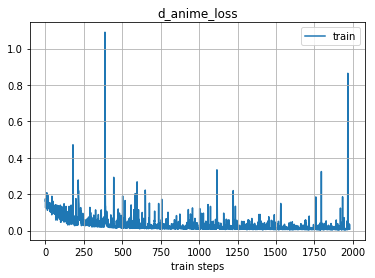

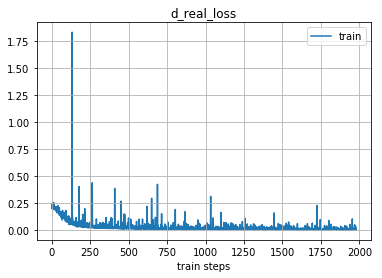

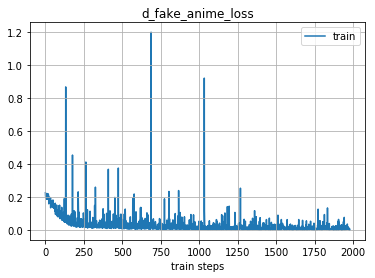

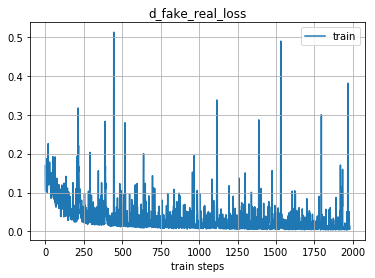

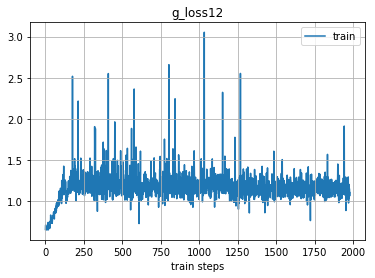

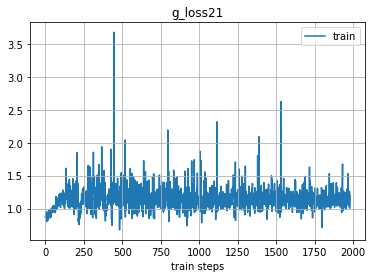

(3, 320, 640)
[0, 64, 0, 64]
(3, 64, 64) (3, 64, 64)
[0, 64, 128, 192]
(3, 64, 64) (3, 64, 64)
[0, 64, 256, 320]
(3, 64, 64) (3, 64, 64)
[0, 64, 384, 448]
(3, 64, 64) (3, 64, 64)
[0, 64, 512, 576]
(3, 64, 64) (3, 64, 64)
[64, 128, 0, 64]
(3, 64, 64) (3, 64, 64)
[64, 128, 128, 192]
(3, 64, 64) (3, 64, 64)
[64, 128, 256, 320]
(3, 64, 64) (3, 64, 64)
[64, 128, 384, 448]
(3, 64, 64) (3, 64, 64)
[64, 128, 512, 576]
(3, 64, 64) (3, 64, 64)
[128, 192, 0, 64]
(3, 64, 64) (3, 64, 64)
[128, 192, 128, 192]
(3, 64, 64) (3, 64, 64)
[128, 192, 256, 320]
(3, 64, 64) (3, 64, 64)
[128, 192, 384, 448]
(3, 64, 64) (3, 64, 64)
[128, 192, 512, 576]
(3, 64, 64) (3, 64, 64)
[192, 256, 0, 64]
(3, 64, 64) (3, 64, 64)
[192, 256, 128, 192]
(3, 64, 64) (3, 64, 64)
[192, 256, 256, 320]
(3, 64, 64) (3, 64, 64)
[192, 256, 384, 448]
(3, 64, 64) (3, 64, 64)
[192, 256, 512, 576]
(3, 64, 64) (3, 64, 64)
[256, 320, 0, 64]
(3, 64, 64) (3, 64, 64)
[256, 320, 128, 192]
(3, 64, 64) (3, 64, 64)
[256, 320, 256, 320]
(3, 64, 64

In [10]:
import sys

def str2bool(v):
    return v.lower() in ('true')

def main(config, real=None, anime=None):
    real_loader, anime_loader = get_loader(config, real, anime)
    
    solver = Solver(config, real_loader, anime_loader)
    cudnn.benchmark = True 
    
    # create directories if not exist
    if not os.path.exists(config.model_path):
        os.makedirs(config.model_path)
    if not os.path.exists(config.sample_path):
        os.makedirs(config.sample_path)
    
    if config.mode == 'train':
        solver.train()
    elif config.mode == 'sample':
        solver.sample()



print(config)

t = time()
main(config, real, anime)
print(time()-t)

In [4]:
import imageio
with imageio.get_writer('./samples/res_ar.gif', mode='I', duration=0.5) as writer:
    for i, filename in enumerate(os.listdir('./samples/')):
        if "a-r" in filename and not i % 5:
            image = imageio.imread('./samples/' + filename)
            writer.append_data(image)

In [39]:
g12 = G(conv_dim=64)
g21 = G(conv_dim=64)
d1 = D(conv_dim=64)
d2 = D(conv_dim=64)
real_loader, anime_loader = get_loader(config, load=True)
real_iter = iter(real_loader)
anime_iter = iter(anime_loader)
solver = Solver(config, real_loader, anime_loader)
# fixed anime and real for sampling

fixed_real = solver.to_var(real_iter.next()[:25])
fixed_anime = solver.to_var(anime_iter.next()[:25])

step=35000
# if step ==0:
#     continue
# save the model parameters for each epoch
g12_path = os.path.join(solver.model_path, 'g12-%d.pkl' %(step))
g21_path = os.path.join(solver.model_path, 'g21-%d.pkl' %(step))
d1_path = os.path.join(solver.model_path, 'd1-%d.pkl' %(step))
d2_path = os.path.join(solver.model_path, 'd2-%d.pkl' %(step))

g12.load_state_dict(torch.load(g12_path))
g21.load_state_dict(torch.load(g21_path))
d1.load_state_dict(torch.load(d1_path))
d2.load_state_dict(torch.load(d2_path))
g12.cuda()
g21.cuda()
d1.cuda()
d2.cuda()
    
    
    
fake_real = g12(fixed_anime)
fake_anime = g21(fixed_real)

anime, fake_anime = solver.to_data(fixed_anime), solver.to_data(fake_anime)
real , fake_real = solver.to_data(fixed_real), solver.to_data(fake_real)

merged = solver.merge_images(anime, fake_real,k=0)
path = os.path.join(config.sample_path, 'sample-%d-a-r.png' %(step+1))
io.imsave("/home/vary10/notebooks/k.jpg", merged)
print ('saved %s' %path)

merged = solver.merge_images(real, fake_anime,k=0)
path = os.path.join(config.sample_path, 'sample-%d-r-a.png' %(step+1))
scipy.misc.imsave("/home/vary10/notebooks/a.jpg", merged)
print ('saved %s' %path)




/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
(3, 320, 640)
[0, 64, 0, 64]
(3, 64, 64) (3, 64, 64)
[0, 64, 128, 192]
(3, 64, 64) (3, 64, 64)
[0, 64, 256, 320]
(3, 64, 64) (3, 64, 64)
[0, 64, 384, 448]
(3, 64, 64) (3, 64, 64)
[0, 64, 512, 576]
(3, 64, 64) (3, 64, 64)
[64, 128, 0, 64]
(3, 64, 64) (3, 64, 64)
[64, 128, 128, 192]
(3, 64, 64) (3, 64, 64)
[64, 128, 256, 320]
(3, 64, 64) (3, 64, 64)
[64, 128, 384, 448]
(3, 64, 64) (3, 64, 64)
[64, 128, 512, 576]
(3, 64, 64) (3, 64, 64)
[128, 192, 0, 64]
(3, 64, 64) (3, 64, 64)
[128, 192, 128, 192]
(3, 64, 64) (3, 64, 64)
[128, 192, 256, 320]
(3, 64, 64) (3, 64, 64)
[128, 192, 384, 448]
(3, 64, 64) (3, 64, 64)
[128, 192, 512, 576]
(3, 64, 64) (3, 64, 64)
[192, 256, 0, 64]
(3, 64, 64) (3, 64, 64)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


saved ./samples/sample-35001-a-r.png
(3, 320, 640)
[0, 64, 0, 64]
(3, 64, 64) (3, 64, 64)
[0, 64, 128, 192]
(3, 64, 64) (3, 64, 64)
[0, 64, 256, 320]
(3, 64, 64) (3, 64, 64)
[0, 64, 384, 448]
(3, 64, 64) (3, 64, 64)
[0, 64, 512, 576]
(3, 64, 64) (3, 64, 64)
[64, 128, 0, 64]
(3, 64, 64) (3, 64, 64)
[64, 128, 128, 192]
(3, 64, 64) (3, 64, 64)
[64, 128, 256, 320]
(3, 64, 64) (3, 64, 64)
[64, 128, 384, 448]
(3, 64, 64) (3, 64, 64)
[64, 128, 512, 576]
(3, 64, 64) (3, 64, 64)
[128, 192, 0, 64]
(3, 64, 64) (3, 64, 64)
[128, 192, 128, 192]
(3, 64, 64) (3, 64, 64)
[128, 192, 256, 320]
(3, 64, 64) (3, 64, 64)
[128, 192, 384, 448]
(3, 64, 64) (3, 64, 64)
[128, 192, 512, 576]
(3, 64, 64) (3, 64, 64)
[192, 256, 0, 64]
(3, 64, 64) (3, 64, 64)
[192, 256, 128, 192]
(3, 64, 64) (3, 64, 64)
[192, 256, 256, 320]
(3, 64, 64) (3, 64, 64)
[192, 256, 384, 448]
(3, 64, 64) (3, 64, 64)
[192, 256, 512, 576]
(3, 64, 64) (3, 64, 64)
[256, 320, 0, 64]
(3, 64, 64) (3, 64, 64)
[256, 320, 128, 192]
(3, 64, 64) (3, 64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


saved ./samples/sample-35001-r-a.png
